# Feature and Structure Independence

### Libs

In [1]:
## libs 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools
import time
import math

## Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 
import scipy.stats as stats
from scipy.stats import wasserstein_distance

## Data Wrangling
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## node colour
orig_cmap = plt.cm.PuBu

Using TensorFlow backend.


### Supporting Function

In [2]:
## supporting functions
from support.preprocessing import sort_adj, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, pad_attr, unpad_attr, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single_features, generate_manifold_features
from support.latent_space import vis2D, visDistr
from support.comparing import compare_manifold_adjacency, compare_topol_manifold
from support.plotting import shiftedColorMap

## graph sampling
from sampling import ForestFire, Metropolis_Hastings, Random_Walk, Snowball, Ties, Base_Samplers

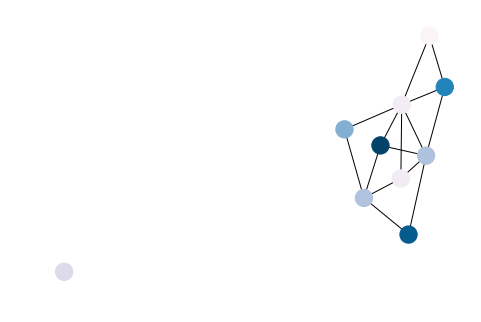

In [3]:
def get_graph(n,p,draw): 

    g = random_graphs.erdos_renyi_graph(n, p, seed=None, directed=False)

    if draw:
        f = np.random.rand(n)
        orig_cmap = plt.cm.PuBu
        fixed_cmap = shiftedColorMap(orig_cmap, start=min(f), midpoint=0.5, stop=max(f), name='fixed')
        nx.draw(g, node_color=f, font_color='white', cmap = fixed_cmap)
        plt.show()
    
    return g

g = get_graph(n = 10, p = 0.4, draw = True)

In [4]:
def generate_features(dataArgs, g, n, p):
    
        if dataArgs["feature_dependence"] == "random":
            f = np.random.rand(n, dataArgs["n_features"])                   ## float
            #F[i] = np.random.randint(2, size=(dataArgs["n_max"],dataArgs["n_features"]))   ## int
            
        if dataArgs["feature_dependence"] == "norm_degree":
            if dataArgs["n_features"] == 1:
                
                f = np.asarray([int(x[1]) for x in sorted(g.degree())])  
                f = (f) / (max(f)+1)
                f = np.reshape(f, (f.shape[-1],1))
                
                    
        if dataArgs["feature_dependence"] == "degree":
            if dataArgs["n_features"] == 1:
                
                f = np.asarray([int(x[1]) for x in sorted(g.degree())])  
                f = (f+1) / (dataArgs["n_max"]+1)
                f = np.reshape(f, (f.shape[-1],1))
                
                
        if dataArgs["feature_dependence"] == "p":  
            if dataArgs["n_features"] == 1:
                f = np.ones((n , 1)) * p
                
        return f

In [5]:
def generate_data(dataArgs): 
    
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
    F = np.zeros((dataArgs["n_graphs"], dataArgs["n_max"], dataArgs["n_features"]))
    print("feature_dependence:",dataArgs["feature_dependence"] )
    
    
    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):
        
        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            n = dataArgs["n_max"] # generate fixed number of nodes n_max
        else:
            n = random.randint(1, dataArgs["n_max"]) # generate number of nodes n between 1 and n_max and

            
        p = np.random.rand(1)  # float in range 0 - 1 
        g = get_graph(n, p, draw = False)
                     
        #nx.draw(g, cmap=plt.get_cmap('PuBu'), node_color=np.squeeze(f), font_color='white')
        #plt.show()
        
        g, a = sort_adj(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal        
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])
        
        
        ## Generate / Load Node Features ______________________________________________
        f = generate_features(dataArgs, g, n, p)
        
        ## pad features with zeroes
        f = pad_attr(f, dataArgs)

        
        ## Build Data Arrays___________________________________________________

        F[i] = f
        G[i] = a_transformed


    ## Input and Output Size ___________________________________________________________

    input_shape, output_shape = prepare_in_out(dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]), F.shape)
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    ## scale features in F for smoother training
    #scaler = MinMaxScaler()
    #scaler.fit(F)
    #F = scaler.transform(F)
    
    return G, F, input_shape,output_shape
    
dataArgs = {"n_graphs": 10000, "n_max": 12, "feature_dependence": "degree", "fix_n": False, "diag_offset": -2, "diag_value": 1, "clip": True, "n_features": 1}  #"diag_offset" - 1 == full adjacency
G, F, input_shape, output_shape = generate_data(dataArgs)

feature_dependence: degree



input_shape: ((12, 1), (12, 12, 1)) , output_shape: ((12, 1), (12, 12, 1))


# beta-VAE Model

In [6]:
## Model Setup
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Dropout, Activation, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
from support.keras_dgl.utils import *
from support.keras_dgl.layers import MultiGraphCNN


class VAE():

    # reparameterization trick
    # instead of sampling from Q(z|X), sample eps = N(0,I)
    # then z = z_mean + sqrt(var)*eps

    def sampling(self, args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    
    
    def __init__(self, modelArgs, trainArgs, g_train, g_test, g_train_mod, g_test_mod, f_train, f_test):

        ## MODEL ______________________________________________________________       
            
        ## Graph Neural Network Architecture __________________________________
            
        ## 1) build encoder model____________________________________

        # build graph_conv_filters
        SYM_NORM = True
        num_filters = 2
        print("g_train shape:", g_train.shape)
        graph_conv_filters = preprocess_adj_tensor_with_identity(np.squeeze(g_train), SYM_NORM)

        # build model
        X_input = Input(shape=(f_train.shape[1], f_train.shape[2]))
        graph_conv_filters_input = Input(shape=(graph_conv_filters.shape[1], graph_conv_filters.shape[2]))

        # define inputs of features and graph topologies
        inputs = [X_input, graph_conv_filters_input]

        x = MultiGraphCNN(100, num_filters, activation='elu')([X_input, graph_conv_filters_input])
        x = Dropout(0.2)(x)
        x = MultiGraphCNN(100, num_filters, activation='elu')([x, graph_conv_filters_input])
        x = Dropout(0.2)(x)
        x = Lambda(lambda x: K.mean(x, axis=1))(x)  # adding a node invariant layer to make sure output does not depends upon the node order in a graph.
        z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
        z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])


        ## 2.1) build topology decoder model __________________________

        ## shape info needed to build decoder model
        inputs_2D_encoder = Input(shape=modelArgs["input_shape"][1], name='encoder_input')
        x_2D = inputs_2D_encoder
        for i in range(2):
            modelArgs['filters'] *= 2
            x_2D = Conv2D(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu',strides=2, padding='same')(x_2D)
        shape_2D = K.int_shape(x_2D)

        latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
        x_2D = Dense(shape_2D[1] * shape_2D[2] * shape_2D[3], activation='relu')(latent_inputs)
        x_2D = Reshape((shape_2D[1], shape_2D[2], shape_2D[3]))(x_2D)

        for i in range(2):
            x_2D = Conv2DTranspose(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'],activation='relu', strides=2, padding='same')(x_2D)
            modelArgs['filters'] //= 2

        topol_output = Conv2DTranspose(filters=1, kernel_size=modelArgs['kernel_size'], activation='sigmoid',padding='same', name='decoder_output')(x_2D)


        ## 2.2) build attribute decoder model __________________________

        y = Dense(4, activation='linear')(latent_inputs)
        y = Dense(10, activation='linear')(latent_inputs)
        y = Dense(modelArgs["output_shape"][0][0], activation='sigmoid')(y)
        attr_output = Reshape(modelArgs["output_shape"][0])(y)

     
    
        ## INSTANTIATE___________________________________

        encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        encoder.summary()

        ## 2.1) instantiate topology decoder model
        topol_decoder = Model(latent_inputs, topol_output, name='topol_decoder')
        topol_decoder.summary()
        
        ## 2.2) instantiate feature decoder model
        attr_decoder = Model(latent_inputs, attr_output, name='attr_decoder')
        attr_decoder.summary()

        
        ## 3) instantiate VAE model
        attr_outputs = topol_decoder(encoder(inputs)[2])
        topol_outputs = attr_decoder(encoder(inputs)[2])
        vae = Model(inputs, [attr_outputs, topol_outputs], name='vae')

    

        ## LOSS FUNCTIONS ______________________________________
        
        def attr_loss_func(y_true, y_pred):

            ## RECONSTRUCTION LOSS_______________________            
            ## mean squared error
            attr_reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
            attr_reconstruction_loss *= modelArgs["input_shape"][0][0]
                            
            ## KL LOSS _____________________________________________

            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5

            ## COMPLETE LOSS __________________________________________________

            #loss = K.mean(attr_reconstruction_loss + (trainArgs["beta"] * kl_loss))
            loss = K.mean(attr_reconstruction_loss)
            
            return loss
        
        
        
        def topol_loss_func(y_true, y_pred):
            
            ## RECONSTRUCTION LOSS_______________________
            ## binary cross-entropy
            topol_reconstruction_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
            topol_reconstruction_loss *= (modelArgs["input_shape"][1][0] * modelArgs["input_shape"][1][1])
                            
            ## KL LOSS _____________________________________________

            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5

            ## COMPLETE LOSS __________________________________________________

            loss = K.mean(topol_reconstruction_loss + (trainArgs["beta"] * kl_loss))

            return loss
        
    
    
    
        ## MODEL COMPILE______________________________________________
        
        vae.compile(optimizer='adam', loss={"attr_decoder": attr_loss_func, "topol_decoder": topol_loss_func})
        vae.summary()
        
        

        ## TRAIN______________________________________________

        # load the autoencoder weights

        if trainArgs["weights"] == "load":

            vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

        # train the autoencoder

        elif trainArgs["weights"] == "train":

            # Set callback functions to early stop training and save the best model so far
            callbacks = [EarlyStopping(monitor='val_loss', patience=trainArgs["early_stop"]), ModelCheckpoint(filepath="models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5",save_best_only=True)]

            vae.fit([f_train, g_train_mod], {"attr_decoder": f_train, "topol_decoder": g_train}, epochs=trainArgs["epochs"],batch_size=trainArgs["batch_size"], callbacks=callbacks,validation_data=([f_test, g_test_mod], {"attr_decoder": f_test, "topol_decoder": g_test}))
            vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

            self.model = (encoder, topol_decoder, attr_decoder)

### Data Split

In [37]:
trainArgs = {"beta": 1, "loss": "mse", "weights": "train", "early_stop": 1, "batch_size": 16, "epochs": 50, "data_split": 0.2}
modelArgs = {"nn_architecture": "gnn", "latent_dim": 4, "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape, "param_loss": False,}

from support.keras_dgl.utils import *
from support.keras_dgl.layers import MultiGraphCNN

## Train and Validation Split _______________________________________________
g_train, g_test, f_train, f_test = train_test_split(G, F, test_size=trainArgs["data_split"], random_state=1, shuffle=True)

# build graph_conv_filters
SYM_NORM = True
g_train_mod = preprocess_adj_tensor_with_identity(np.squeeze(g_train), SYM_NORM)
g_test_mod = preprocess_adj_tensor_with_identity(np.squeeze(g_test), SYM_NORM)

data = (f_test, [g_test_mod, g_test])

### Train

In [38]:
vae = VAE(modelArgs, trainArgs, g_train, g_test, g_train_mod, g_test_mod, f_train, f_test)
models = vae.model 

g_train shape: (8000, 12, 12, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 12, 1)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 24, 12)       0                                            
__________________________________________________________________________________________________
multi_graph_cnn_3 (MultiGraphCN (None, 12, 100)      300         input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 12, 100)      0           multi_graph

8000/8000 [==============================] - 3s 365us/step - loss: 25.7513 - topol_decoder_loss: 25.6843 - attr_decoder_loss: 0.0670 - val_loss: 24.3243 - val_topol_decoder_loss: 24.2610 - val_attr_decoder_loss: 0.0632
Epoch 9/50
8000/8000 [==============================] - 3s 370us/step - loss: 25.4912 - topol_decoder_loss: 25.4254 - attr_decoder_loss: 0.0658 - val_loss: 24.0908 - val_topol_decoder_loss: 24.0274 - val_attr_decoder_loss: 0.0634
Epoch 10/50
8000/8000 [==============================] - 3s 416us/step - loss: 25.2096 - topol_decoder_loss: 25.1444 - attr_decoder_loss: 0.0652 - val_loss: 23.8421 - val_topol_decoder_loss: 23.7808 - val_attr_decoder_loss: 0.0613
Epoch 11/50
8000/8000 [==============================] - 4s 443us/step - loss: 25.1477 - topol_decoder_loss: 25.0833 - attr_decoder_loss: 0.0644 - val_loss: 23.6420 - val_topol_decoder_loss: 23.5817 - val_attr_decoder_loss: 0.0603
Epoch 12/50
8000/8000 [==============================] - 3s 396us/step - loss: 24.9817 - 

# Analysis

### Generate Single

latent dimensions: 4
nodes_n: 6
node attributes: [0.34979033 0.30993432 0.26724052 0.233327   0.20233592 0.16290969]


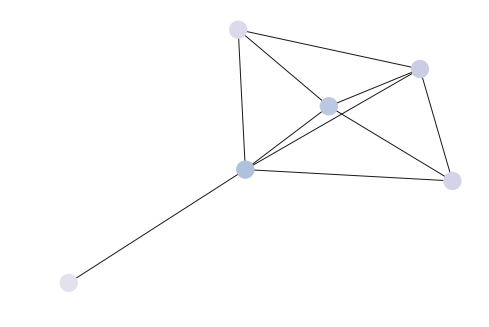

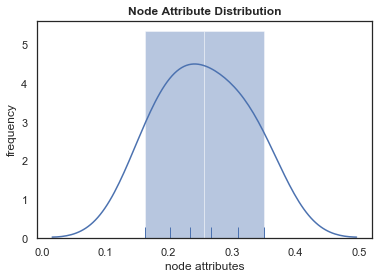

In [39]:
analyzeArgs = {"z": [0,1], "activations": [0,-1], "normalize_feature": False}
generate_single_features(analyzeArgs, modelArgs, dataArgs, models, orig_cmap)

### Generate Manifold

latent dimensions: 4


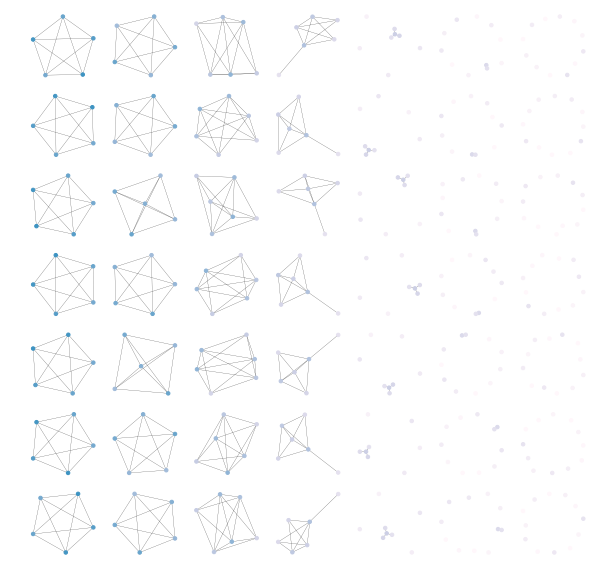

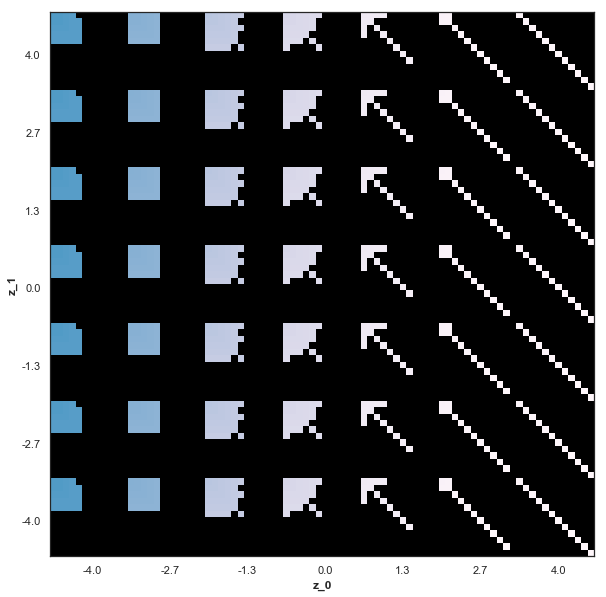

In [99]:
# range, normal, z
analyzeArgs = {"z": [0,1], "sample": "range", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 7, "save_plots": False, "normalize_feature": False}
generate_manifold_features(analyzeArgs, modelArgs, dataArgs, models, data, orig_cmap, batch_size=trainArgs["batch_size"])

## Modification (Nullhypothesis Testing)

ground truth attribute dependence:  degree

latent variable z_ 0
average_mean_shift: 0.03224416971206665
average_wasserstein_dist: 0.044601349546750914


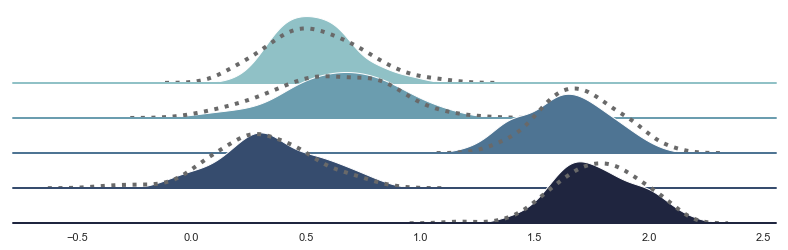


latent variable z_ 1
average_mean_shift: 0.000833013653755188
average_wasserstein_dist: 0.14148381075129743


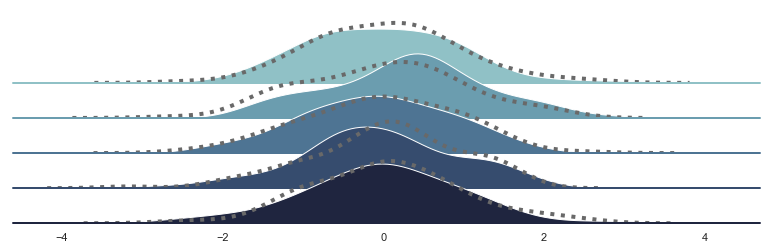


latent variable z_ 2
average_mean_shift: 0.0014319244772195816
average_wasserstein_dist: 0.16948058452747822


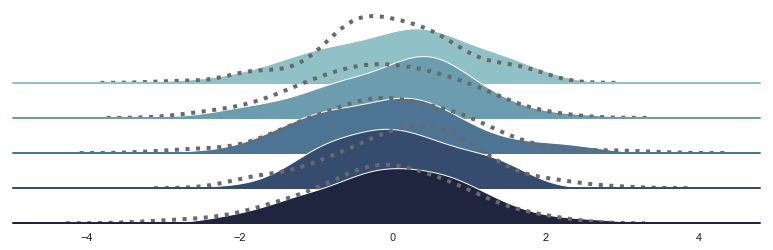


latent variable z_ 3
average_mean_shift: 0.00478435754776001
average_wasserstein_dist: 0.02046947837536134


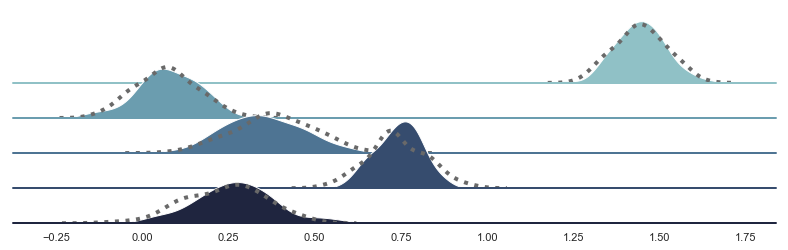

In [100]:
def modification_comparison(analyzeArgs, modelArgs, models, data, batch_size=128,model_name="vae_graph"):

    ## unpack models and data__________________________
    
    encoder, topol_decoder, attr_decoder = models  # trained models
    F_org, [A_fil, A] = data

    F_mod = np.copy(F_org)
    
    for i, (f,a) in enumerate(zip(F_mod, A)):

        ## Generate Graph Type ______________________________________________
            
        reconstructed_a, nodes_n = unpad_matrix(a, dataArgs["diag_value"], 0.2, dataArgs["fix_n"])
        f = unpad_attr(f, nodes_n, analyzeArgs, dataArgs)
        f = np.reshape(f, (f.shape[0], 1)) ## reshape to (n,n_features)
        
        if analyzeArgs["f_variation"] == "random":
            for mod in range(0, int(analyzeArgs["mod_degree"] * nodes_n)):
                swap = np.random.randint(low = 0, high = nodes_n, size = 2)
                temp = np.copy(f[swap[0]])
                f[swap[0]] = f[swap[1]]
                f[swap[1]] = temp


        elif analyzeArgs["f_variation"] == "equal":
    
            norm_std = analyzeArgs["mod_degree"]
            norm_mean = np.mean(f) 
            
            for i in range(0,len(f)):
                
                if f[i] > norm_mean:
                    f[i] = f[i] - (norm_std * (np.abs(f[i] - norm_mean)))
                else:
                    f[i] = f[i] + (norm_std * (np.abs(f[i] - norm_mean )))
                    
                    
        elif analyzeArgs["f_variation"] == "uniform":
    
            f = np.ones(f.shape[0]) * analyzeArgs["mod_degree"]
            f = np.reshape(f, (f.shape[-1],1))
                    
        
        ## pad features with zeroes
        f = pad_attr(f, dataArgs)
        

    
    ## ENCODER - 2D Digit Classes ______________________________________________
        
    z_mean, z_log_var, _ = encoder.predict([F_org, A_fil], batch_size = batch_size)
    z_mean_mod, z_log_var_mod, _ = encoder.predict([F_mod, A_fil], batch_size = batch_size)
        
        
    ## toDO: measure the correlation between latent variable and the generative factor / features
    
    ## Feature Change ____________________________ 
        
    z_mean = np.abs(z_mean[:analyzeArgs["n_graphs"]])
    z_mean_mod = np.abs(z_mean_mod[:analyzeArgs["n_graphs"]])
    z_var = np.exp(0.5 * z_log_var)[:analyzeArgs["n_graphs"]]
    z_var_mod = np.exp(0.5 * z_log_var_mod)[:analyzeArgs["n_graphs"]]
    
    for latent_i in range(0, modelArgs["latent_dim"]):   
        
        Normal_org = np.array([])
        Normal_mod = np.array([])
        total_mean_shift = 0
        total_emd = 0
                
        for graph_i in range(0, analyzeArgs["n_graphs"]):

            ## compute shift and EMD
            mean_shift = np.abs(z_mean[graph_i, latent_i] - z_mean_mod[graph_i, latent_i])
            total_mean_shift += mean_shift

            #x = np.linspace(z_mean[graph_i, latent_i] - 3*math.sqrt(z_var[graph_i, latent_i]), z_mean[graph_i, latent_i] + 3*math.sqrt(z_var[graph_i, latent_i]), 1000)
            #y = stats.norm.pdf(x, z_mean[graph_i, latent_i], math.sqrt(z_var[graph_i, latent_i]))
            #plt.plot(x, y, color='midnightblue', linestyle='solid', linewidth=4)
            normal_org = np.random.normal(z_mean[graph_i, latent_i], z_var[graph_i, latent_i], analyzeArgs["norm_samples"])
            Normal_org = np.hstack((Normal_org, normal_org))
            #sns.distplot(normal_org)
            
            #x_mod = np.linspace(z_mean_mod[graph_i, latent_i] - 3*math.sqrt(z_var_mod[graph_i, latent_i]), z_mean_mod[graph_i, latent_i] + 3*math.sqrt(z_var_mod[graph_i, latent_i]), 1000)
            #y_mod = stats.norm.pdf(x_mod, z_mean_mod[graph_i, latent_i], math.sqrt(z_var_mod[graph_i, latent_i]))
            #plt.plot(x_mod, y_mod, color='steelblue', linestyle='dashed', linewidth=4)
            normal_mod = np.random.normal(z_mean_mod[graph_i, latent_i], z_var_mod[graph_i, latent_i], analyzeArgs["norm_samples"])
            Normal_mod = np.hstack((Normal_mod, normal_mod))
            #sns.distplot(normal_mod)
            
            #plt.xlabel('latent posterior z_' + str(latent_i), fontweight = "bold")
            #plt.annotate("mean shift:" + str(mean_shift) , xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')
            total_emd += wasserstein_distance(normal_org, normal_mod)

        sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

        # Create the data
        #g = np.tile(list("ABCDEFGHIJ"), 1000) # size 1000
        x = np.arange(0, analyzeArgs["n_graphs"], 1)
        x = np.repeat(x, analyzeArgs["norm_samples"])
        df = pd.DataFrame(dict(org=Normal_org, mod=Normal_mod, x=x))

        #m = df.g.map(ord)  ## offset
        #df["x"] += m

        # Initialize the FacetGrid object
        pal = sns.cubehelix_palette(analyzeArgs["n_graphs"], rot=-.25, light=.7)
        g = sns.FacetGrid(df, row="x", hue="x", aspect=15, height=.75, palette=pal)

        # Draw the densities in a few steps
        #g.map(sns.kdeplot, "org", clip_on=False, shade=True, color="red", alpha=1.0, lw=1.5, bw=.2)
        #g.map(sns.kdeplot, "org", clip_on=False, shade=True, alpha=1.0, lw=2, bw=.2)
        g.map(sns.distplot, "org", hist = False, kde = True, kde_kws={'linewidth': 0, "shade": True, "alpha": 1.0})
        #g.map(sns.kdeplot, "mod", clip_on=False, shade=True, alpha=1.0, lw=1.5, bw=.2)
        #g.map(sns.kdeplot, "mod", clip_on=False, shade=False, color="orange", alpha=1.0, lw=2, bw=.2)
        g.map(sns.distplot, "mod", color="dimgrey", hist = False, kde = True, bins = 1000, kde_kws={'linestyle':':', 'linewidth': 4})
        g.map(plt.axhline, y=0, lw=2, clip_on=False)


        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                    ha="left", va="center", transform=ax.transAxes)

        #g.map(label, "x")

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.5)

        # Remove axes details that don't play well with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)
        
        print("\nlatent variable z_", latent_i)
        print("average_mean_shift:", total_mean_shift / analyzeArgs["n_graphs"])
        print("average_wasserstein_dist:", total_emd / analyzeArgs["n_graphs"])
        
        plt.pause(0.05)


        
## PLOT RESULTS ________________________________________
print("ground truth attribute dependence: ", dataArgs["feature_dependence"])
analyzeArgs = {"mod_degree": 1.0, "n_graphs": 5, "f_variation": "random", "norm_samples": 100, "metric": "none", "normalize_feature": False}
modification_comparison(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Latent Variable Correlation


original features:
 [[0.30769231]
 [0.23076923]
 [0.15384615]
 [0.15384615]
 [0.15384615]]


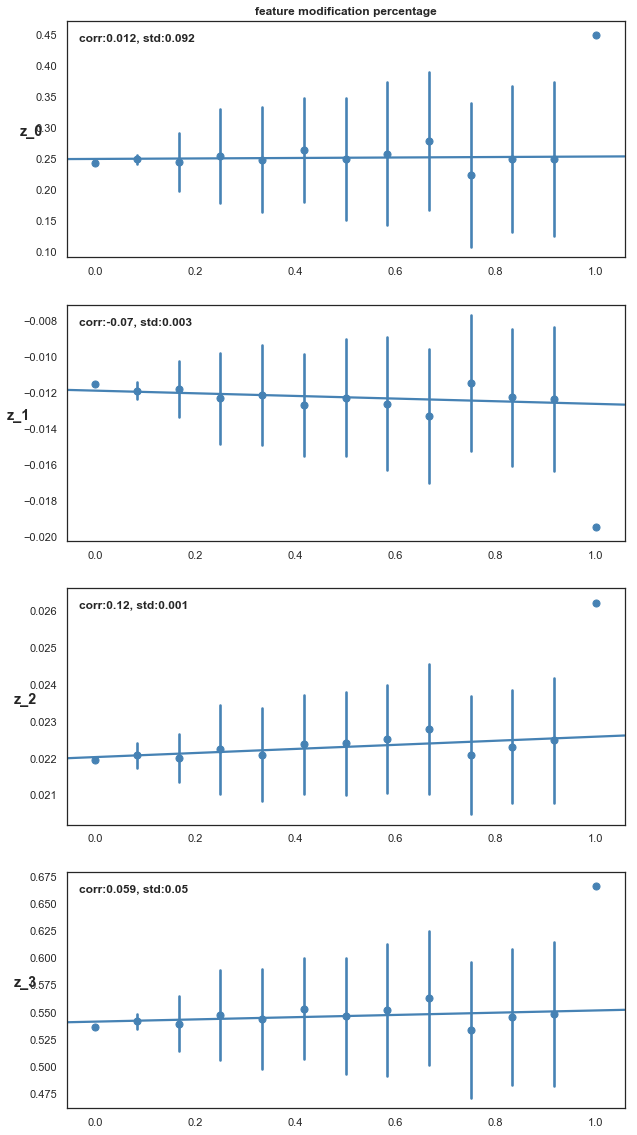

In [93]:
def feature_latent_correlation(analyzeArgs, modelArgs, models, data, batch_size=128,model_name="vae_graph"):

    
    ## unpack models and data__________________________
    
    encoder, topol_decoder, attr_decoder = models  # trained models
    #F, [A_fil, A] = data
    
    ## generate input network _________________________
    
    g = get_graph(analyzeArgs["n"], analyzeArgs["p"], draw = False) 
    g, a = sort_adj(g)
    a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal        
    a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])
    A = np.reshape(a_transformed, (1, *a_transformed.shape))
    A = np.tile(A, (analyzeArgs["mod_steps"],1,1,1))
    
    SYM_NORM = True
    A_fil = preprocess_adj_tensor_with_identity(np.squeeze(A), SYM_NORM)
    
        
    f = generate_features(dataArgs, g, analyzeArgs["n"], analyzeArgs["p"]) 
    print("original features:\n", f)
    
    F_mod = np.zeros((analyzeArgs["mod_steps"], dataArgs["n_max"], dataArgs["n_features"]))
        
                 
    ## Modify Features__________________________________
                 
    mod_degree = np.linspace(0,dataArgs["n_max"],analyzeArgs["mod_steps"], dtype = int) 
    
    for i, mod in enumerate(mod_degree):
        
        f_mod = np.copy(f)

        if analyzeArgs["f_variation"] == "random":
            for m in range(0, mod):
                swap = np.random.randint(low = 0, high = f_mod.shape[0], size = 2)
                temp = f[swap[0]]
                f_mod[swap[0]] = f_mod[swap[1]]
                f_mod[swap[1]] = temp


        elif analyzeArgs["f_variation"] == "equal":

            mod_ratio = mod / max(mod_degree)
            norm_mean = np.mean(f)

            for i in range(0,len(f_mod)):

                if f_mod[i] > norm_mean:
                    f_mod[i] = f_mod[i] - (mod_ratio * (np.abs(f_mod[i] - norm_mean)))
                else:
                    f_mod[i] = f_mod[i] + (mod_ratio * (np.abs(f_mod[i] - norm_mean )))


        elif analyzeArgs["f_variation"] == "uniform":

            f_mod = np.ones(f_mod.shape[0]) * (mod / max(mod_degree))
            f_mod = np.reshape(f_mod, (f_mod.shape[-1],1))

        ## pad features with zeroes
        f_mod = pad_attr(f_mod, dataArgs)
        F_mod[i] = f_mod    
        

    ## ENCODER ______________________________________________
    z_mean, _, _ = encoder.predict([F_mod, A_fil], batch_size = batch_size)


    ## Measure the Mutual Information Gap ____________________________________________
    if analyzeArgs["metric"] == "mig":
        mig = compute_mig(mod_degree, np.squeeze(z_mean))
        
        
    ## toDO: measure the correlation between latent variable and the generative factor / features

    ## Visualize Latent Variables x Feature Change ____________________________

    fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= 1, figsize=(10,20))

    for latent_z, row in enumerate(ax):        

            y = z_mean[:,latent_z]
            x = mod_degree / max(mod_degree)
            sns.regplot(x, y, color="steelblue", ax=row, ci = None, x_ci='sd', x_estimator=np.mean)

            ## compute correlation and standardized covariance
            corr = round(pearsonr(x,y)[0],3)
            cov = round(np.cov(x, y)[0][1]/max(x),3)
            std = round(np.std(y),3)
            row.annotate("corr:"+str(corr)+", std:"+str(std), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points', fontweight='bold')

            

    ## add row and column titles _____________________

    rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
    cols = [t for t in ["feature modification percentage"]]

    for axis, col in zip(ax, cols):
        axis.set_title(col, fontweight='bold')

    for axis, row in zip(ax, rows):
        axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')


        
## PLOT RESULTS ________________________________________

dataArgs["feature_dependence"] = "degree"  #"degree", "random", "p"
analyzeArgs = {"n": 5, "p": 0.4, "mod_steps": 1000, "f_variation": "random", "metric": "none", "normalize_feature": False}
feature_latent_correlation(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")